# San Jose Airport Database

## Week 8 Continued
This week, I retrieved the SJC database which includes aviation data from 2016-2023. I cleaned the data and began data visualization.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy.optimize import curve_fit
import math


import hashlib
%matplotlib inline
pd.set_option('mode.chained_assignment', None)


sns.set(style="dark")
# plt.style.use("ggplot")

In [2]:
landings = pd.read_excel("Landed_Stats_Jan_2016-_Feb_2023.xls")
landings.head()

,Unnamed: 0,Jan-2016,Feb-2016,Mar-2016,Apr-2016,May-2016,Jun-2016,Jul-2016,Aug-2016,Sep-2016,...,May-2022,Jun-2022,Jul-2022,Aug-2022,Sep-2022,Oct-2022,Nov-2022,Dec-2022,Jan-2023,Feb-2023
0,Commerical Passenger Airline Landings,3893,3674,4013,3978,4259,4558,4637,4763,4406,...,4655,4951,5136,5188,4988,4987,4844,4328,4656,4138
1,Cargo Airline Landings,64,63,74,67,64,69,59,71,63,...,56,60,53,58,55,58,53,60,59,68
2,Total Landings,3957,3737,4087,4045,4323,4627,4696,4834,4469,...,4711,5011,5189,5246,5043,5045,4897,4388,4715,4206


## Data Cleaning

In [3]:
landings = landings.T
landings = landings.rename(columns={0: "Commerical Passenger Airline Landings", 1: "Cargo Airline Landings", 2: 'Landing Count'})
landings = landings.drop('Unnamed: 0')
landings.reset_index(inplace=True)
landings = landings.rename(columns={'index': 'Dates'})
landings

,Dates,Commerical Passenger Airline Landings,Cargo Airline Landings,Landing Count
0,Jan-2016,3893,64,3957
1,Feb-2016,3674,63,3737
2,Mar-2016,4013,74,4087
3,Apr-2016,3978,67,4045
4,May-2016,4259,64,4323
...,...,...,...,...
81,Oct-2022,4987,58,5045
82,Nov-2022,4844,53,4897
83,Dec-2022,4328,60,4388
84,Jan-2023,4656,59,4715


## Data Visualization

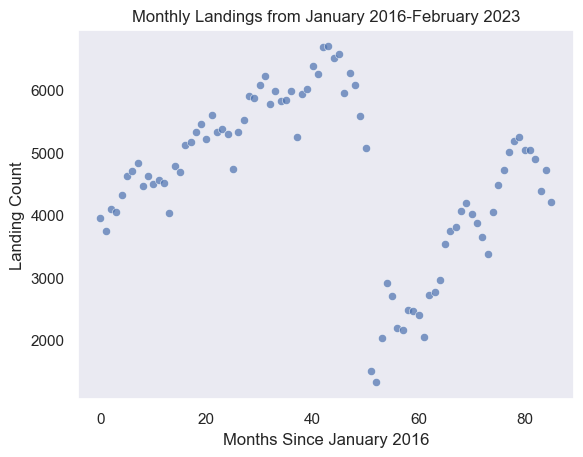

In [4]:
x_axis = np.arange(0, len(landings), 1)
sns.scatterplot(data=landings, x=x_axis, y='Landing Count', s=35, alpha = 0.7);
plt.title("Monthly Landings from January 2016-February 2023")
plt.xlabel("Months Since January 2016");

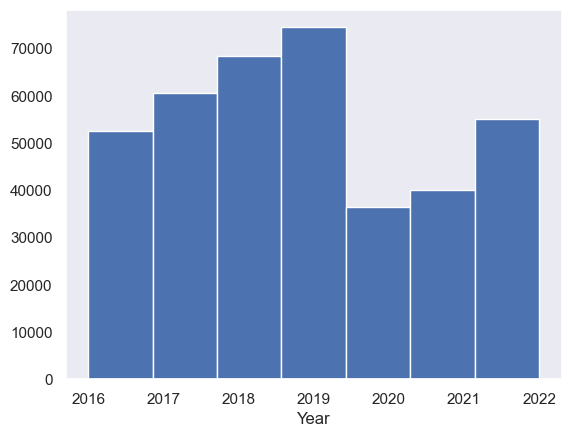

In [5]:
yearly = landings.loc[:, ["Dates", "Landing Count"]]
yearly["Year"] = (yearly.loc[:, "Dates"].str[-4:])
yearly = yearly.drop(columns=["Dates"])
yearly = yearly.groupby("Year").sum()
yearly = yearly.reset_index()
yearly = yearly.drop([len(yearly) - 1])

plt.hist(yearly["Year"], bins=7, weights=yearly["Landing Count"])
# plt.title("Yearly Landings from 2016-2022")
plt.xlabel("Year");
# plt.ylabel("Number of Landings")

#### I removed the 2020-2023 data because we are not considering post-COVID stats. Next, I visualized the average yearly cycle.

In [6]:
month_conversion = {'Jan': 1,
                  'Feb': 2,
                  'Mar': 3, 
                  'Apr': 4,
                  'May': 5,
                  'Jun': 6,
                  'Jul': 7,
                  'Aug': 8,
                  'Sep': 9,
                  'Oct': 10,
                  'Nov': 11,
                  'Dec': 12}

monthly = landings.loc[:, ["Dates", "Landing Count"]]
monthly["Month"] = monthly.loc[:, "Dates"].str[:3]
monthly["Month"] = monthly["Month"].apply(lambda x: month_conversion[x])
monthly["Year"] = monthly.loc[:, "Dates"].str[-4:]
monthly["Year"] = pd.to_numeric(monthly["Year"])
monthly = monthly.drop(columns=["Dates"])
monthly = monthly[monthly["Year"] < 2020]
monthly = monthly.groupby(["Year","Month"]).sum()
monthly = monthly.reset_index()

monthly_avg = monthly.groupby('Month').mean()
monthly_avg = monthly_avg.drop(columns=['Year'])
monthly_avg.rename(columns={'Landing Count': 'Average Landings'}, inplace=True)
monthly_avg.reset_index(inplace=True)
monthly_avg.head()

,Month,Average Landings
0,1,4934.75
1,2,4437.25
2,3,5030.25
3,4,5067.25
4,5,5431.75


#### Normalizing the landings by dividing by the number of days per month:

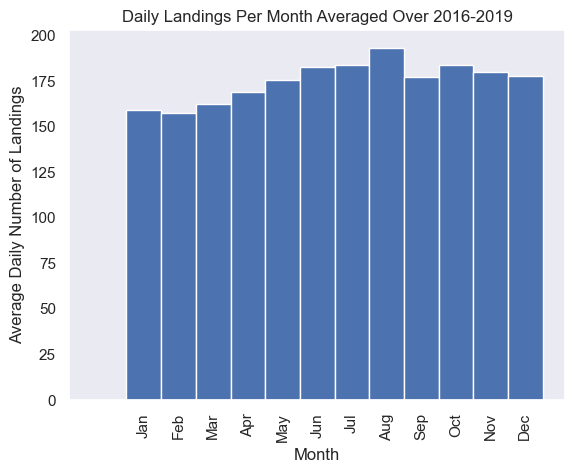

In [7]:
feb_avg = (11 * 28 + 3 * 29) / 14
days_per_month = {1: 31,
                  2: feb_avg,
                  3: 31, 
                  4: 30,
                  5: 31,
                  6: 30,
                  7: 31,
                  8: 30,
                  9: 31,
                  10: 31,
                  11: 30,
                  12: 31}

daily_avg = monthly_avg.copy()
daily_avg['Days Per Month'] = daily_avg['Month'].apply(lambda x: days_per_month[x])
daily_avg['Landings Per Day'] = daily_avg['Average Landings'] / daily_avg['Days Per Month']

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.hist(daily_avg["Month"], bins=np.arange(14)-0.5, weights=daily_avg["Landings Per Day"])
plt.title("Daily Landings Per Month Averaged Over 2016-2019")
plt.xlabel("Month")
plt.xticks(daily_avg["Month"], months, rotation='vertical')
plt.ylabel("Average Daily Number of Landings");

#### Here, we can see the same annual cycle that we have observed for the past two airports.

## Then, I began working on the sinusoidal regression model.

In [8]:
daily_avg_across = monthly.copy()
daily_avg_across['Days Per Month'] = daily_avg_across['Month'].apply(lambda x: days_per_month[x])
daily_avg_across['Landings Per Day'] = daily_avg_across['Landing Count'] / daily_avg_across['Days Per Month']
daily_avg_across.head()

,Year,Month,Landing Count,Days Per Month,Landings Per Day
0,2016,1,3957,31.000000,127.645161
1,2016,2,3737,28.214286,132.450633
2,2016,3,4087,31.000000,131.838710
3,2016,4,4045,30.000000,134.833333
4,2016,5,4323,31.000000,139.451613


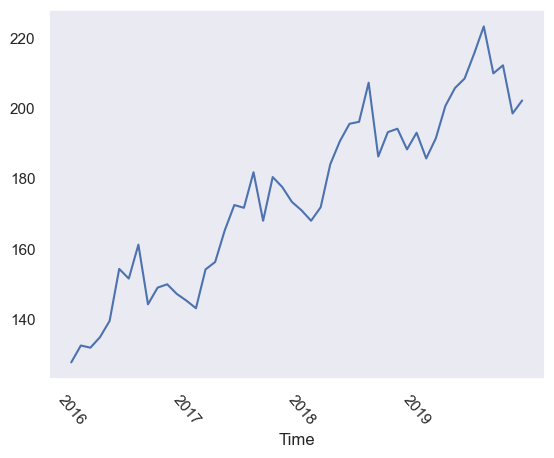

In [9]:
X = np.arange(0, len(daily_avg_across))
y = daily_avg_across['Landings Per Day'].tolist()
plt.plot(X, y)
x_ticks = np.arange(0, len(X), step=12)
x_labels = np.arange(2016, 2020)
plt.xticks(x_ticks, x_labels, rotation=310)
# plt.title("Average Daily Landings Per Month")
plt.xlabel("Time")
# plt.ylabel("Number of Landings per Day")
plt.show()

#### Functions that create the predicted model and get the parameters of the sinusoidal function:

In [10]:
def sinusoid(x,A,offset,omega,phase):
    return A*np.sin(omega*x+phase) + offset

T = 12
def get_p0(x, y):
    A0 = (max(y[0:T]) - min(y[0:T]))/2
    offset0 = y[0]
    phase0 = 0
    omega0 = 2.0*np.pi/T
    return [A0, offset0, omega0, phase0]

#### Fitting the sinusoidal function to the data:

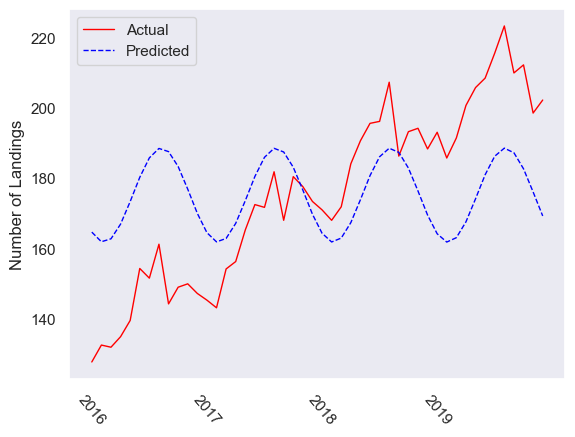

In [11]:
param, covariance = curve_fit(sinusoid, X, y, p0=get_p0(X,y))
plt.xticks(x_ticks, x_labels, rotation=310)
plt.ylabel("Number of Landings")
plt.plot(X, y, color="red", linewidth=1, label="Actual")
plt.plot(X, sinusoid(X, *param), color="blue", linewidth=1, linestyle="dashed", label="Predicted")
plt.legend()
plt.show()

#### Get the maximums and minimums of each year. Then, find the offset of the sine graph:

In [12]:
def get_peaks(y, metrics):
    n = int(math.ceil(len(y)/T))
    step = 0
    x_peaks = []
    y_peaks = []
    for i in np.arange(0, n):
        peak_index = y.index(metrics(y[step:step+T]))
        x_peaks.append(peak_index)
        y_peaks.append(y[peak_index])
        step = step+T
    return [x_peaks,y_peaks]

min_peaks = get_peaks(y,min)
max_peaks = get_peaks(y,max)

In [13]:
A = []
offset = []
for i in range(0, len(min_peaks[1])):
    c_a = (max_peaks[1][i] - min_peaks[1][i])/2
    c_offset = min_peaks[1][i] + c_a
    for j in range(0,T):
        A.append(c_a)
        offset.append(c_offset)

#### Update parameters:

In [14]:
features = [X, A, offset]
def variable_sinusoid(features,omega,phase):
    x = features[0]
    A = features[1]
    offset = features[2]
    return A*np.sin(omega*x+phase) + offset

def variable_get_p0(x, y): 
    phase0 = 0
    omega0 = 2.*np.pi/T
    return [omega0, phase0]

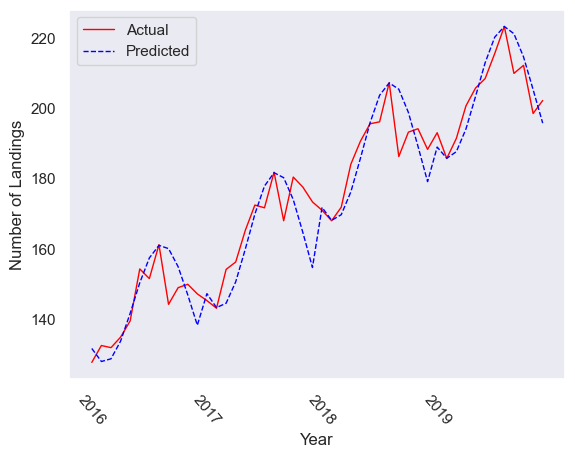

In [15]:
param, covariance = curve_fit(variable_sinusoid, features, y, p0=variable_get_p0(X,y))
plt.xticks(x_ticks, x_labels, rotation=310)
plt.ylabel("Number of Landings")
plt.xlabel("Year")
plt.plot(X, y, color="red", linewidth=1, label = 'Actual')
plt.plot(X, variable_sinusoid(features, *param), color="blue", linestyle="dashed", linewidth=1, label='Predicted')
plt.legend()
plt.show()

### Smoothing Transitions Between Years

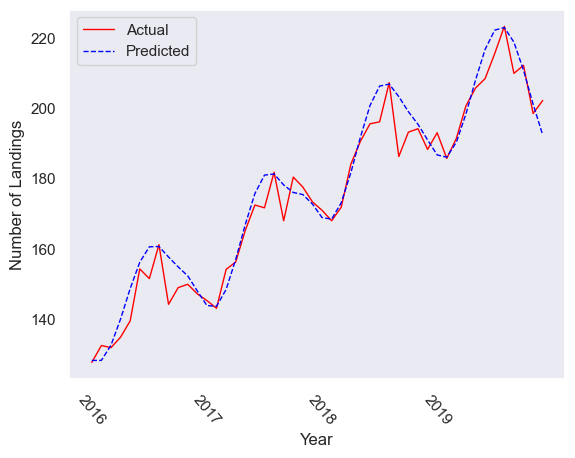

In [16]:
# smooth the features at transisitions
A_smoothed = features[1]+np.diff(features[1],append=features[1][-1])/2
A_smoothed = A_smoothed+np.diff(A_smoothed,append=A_smoothed[-1])/2
A_smoothed = A_smoothed+np.diff(A_smoothed,append=A_smoothed[-1])/2
A_smoothed = A_smoothed+np.diff(A_smoothed,append=A_smoothed[-1])/2

offset_smoothed = features[2]+np.diff(features[2],append=features[2][-1])/2
offset_smoothed = offset_smoothed+np.diff(offset_smoothed,append=offset_smoothed[-1])/2
offset_smoothed = offset_smoothed+np.diff(offset_smoothed,append=offset_smoothed[-1])/2
offset_smoothed = offset_smoothed+np.diff(offset_smoothed,append=offset_smoothed[-1])/2

features_smoothed = [X, A_smoothed, offset_smoothed]


param, covariance = curve_fit(variable_sinusoid, features_smoothed, y, p0=variable_get_p0(X,y))
plt.xticks(x_ticks, x_labels, rotation=310)
plt.ylabel("Number of Landings")
plt.xlabel("Year")
plt.plot(X, y, color="red", linewidth=1, label = 'Actual')
plt.plot(X, variable_sinusoid(features_smoothed, *param), color="blue", linestyle="dashed", linewidth=1, label='Predicted')
plt.legend()
plt.show()

In [17]:
# reshape x_peaks
x_min_peaks = list(map(lambda l:[l], min_peaks[0])) 
x_max_peaks = list(map(lambda l:[l], max_peaks[0]))
# min model
model_min = linear_model.LinearRegression()
model_min.fit(x_min_peaks,min_peaks[1])
# max model
model_max = linear_model.LinearRegression()
model_max.fit(x_max_peaks,max_peaks[1])


yr_to_predict_to = 2025


yrs_into_future = yr_to_predict_to - 2019
for i in range(1, yrs_into_future + 1):
    x_min_peaks.append([x_min_peaks[len(x_min_peaks) -1][0] + T])
    x_max_peaks.append([x_max_peaks[len(x_max_peaks) -1][0] + T])
y_pred_min = model_min.predict(x_min_peaks)
y_pred_max = model_max.predict(x_max_peaks)

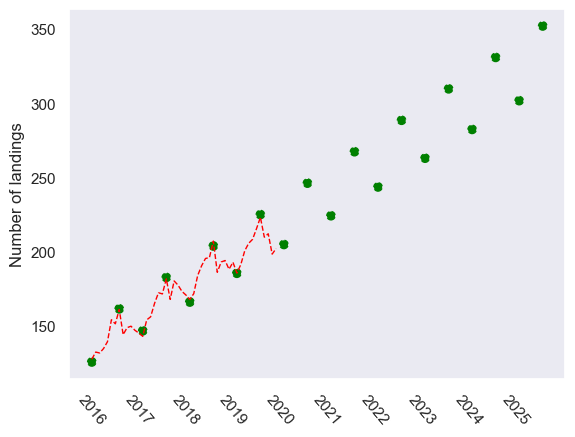

In [18]:
x_ticks_future = np.arange(0, len(X)+yrs_into_future*12, step=12)
x_labels_future = np.arange(2016, yr_to_predict_to + 1)

plt.xticks(x_ticks_future, x_labels_future, rotation=310)
plt.plot(X, y, color="red", linewidth=1,linestyle="dashed")
plt.scatter(x_min_peaks, y_pred_min, color="green", linewidth=1,linestyle="dashed")
plt.scatter(x_max_peaks, y_pred_max, color="green", linewidth=1,linestyle="dashed")
plt.ylabel("Number of landings")
plt.show()

#### Next, I used the linear regression model to plot the expected arrivals in sinusoidal form.

In [19]:
X_pred = np.arange(0, len(X) + T * yrs_into_future)
A_pred = A.copy()
offset_pred = offset.copy()
for i in range(yrs_into_future):
    index = len(max_peaks[1]) + i
    c_a = (y_pred_max[index] - y_pred_min[index])/2
    c_offset = y_pred_min[index] + c_a
    for j in range(0,T):
        A_pred.append(c_a)
        offset_pred.append(c_offset)
    features_pred = [X_pred,A_pred,offset_pred]

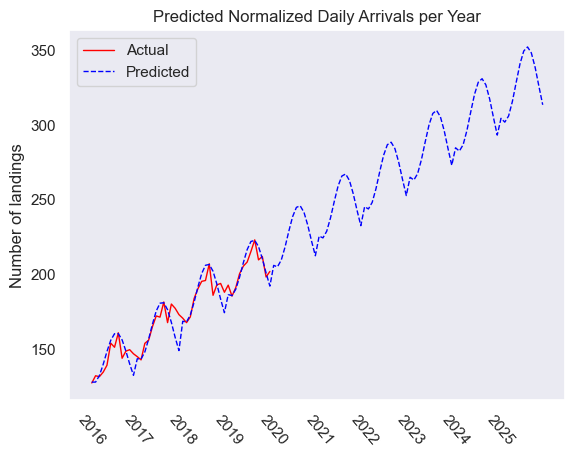

In [20]:
plt.xticks(x_ticks_future, x_labels_future, rotation=310)
plt.plot(X, y, color="red", linewidth=1, label = 'Actual')
plt.plot(X_pred, variable_sinusoid(features_pred, *param), color="blue", linewidth=1, linestyle='dashed', label="Predicted")
plt.ylabel("Number of landings")
plt.title("Predicted Normalized Daily Arrivals per Year")
plt.legend()
plt.show()

### Smoothing Transitions Between Years

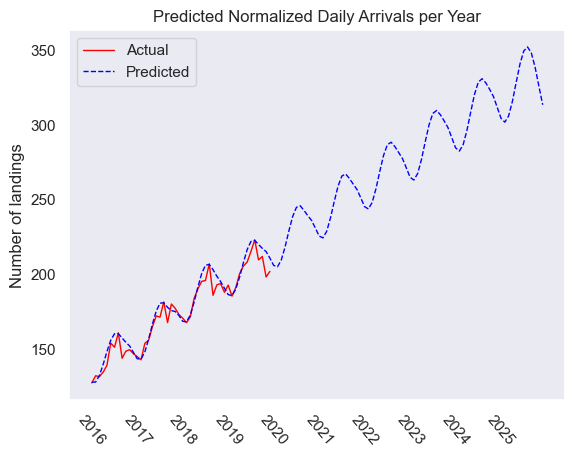

In [21]:
# smooth the features at transitions
A_smoothed = features_pred[1]+np.diff(features_pred[1],append=features_pred[1][-1])/2
A_smoothed = A_smoothed+np.diff(A_smoothed,append=A_smoothed[-1])/2
A_smoothed = A_smoothed+np.diff(A_smoothed,append=A_smoothed[-1])/2
A_smoothed = A_smoothed+np.diff(A_smoothed,append=A_smoothed[-1])/2

offset_smoothed = features_pred[2]+np.diff(features_pred[2],append=features_pred[2][-1])/2
offset_smoothed = offset_smoothed+np.diff(offset_smoothed,append=offset_smoothed[-1])/2
offset_smoothed = offset_smoothed+np.diff(offset_smoothed,append=offset_smoothed[-1])/2
offset_smoothed = offset_smoothed+np.diff(offset_smoothed,append=offset_smoothed[-1])/2

features_smoothed = [X_pred, A_smoothed, offset_smoothed]

plt.xticks(x_ticks_future, x_labels_future, rotation=310)
plt.plot(X, y, color="red", linewidth=1, label = 'Actual')
plt.plot(X_pred, variable_sinusoid(features_smoothed, *param), color="blue", linewidth=1, linestyle='dashed', label="Predicted")
plt.ylabel("Number of landings")
plt.title("Predicted Normalized Daily Arrivals per Year")
plt.legend()
plt.show()


### Because this dataset did not include aircraft types, I researched the most common ones. I found the technical memorandum with predictions for the most common aircraft types in 2037; the report is from 2017:
<img src="extra/aircraft_types.png" style="width:500px;height:600px;">
<caption><center> Figure 1 : Breakdown of different aircraft types</center></caption><br>

#### Import ICAO dataset:

In [22]:
idle_time = 26 * 60
to_time = 0.7 * 60
engines = pd.read_excel("edb-emissions-databank_v29 (web).xlsx", 'Gaseous Emissions and Smoke')
engines = engines[["Engine Identification", "Fuel Flow Idle (kg/sec)", "Fuel Flow T/O (kg/sec)"]]
engines['Idle Fuel (kg)'] = idle_time * engines['Fuel Flow Idle (kg/sec)']
engines['T/O Fuel (kg)'] = to_time * engines['Fuel Flow Idle (kg/sec)']
engines['Fuel Used (kg)'] = engines['T/O Fuel (kg)'] + engines['Idle Fuel (kg)']
engines = engines.drop(columns=["Fuel Flow Idle (kg/sec)", "Fuel Flow T/O (kg/sec)", 'Idle Fuel (kg)', 'T/O Fuel (kg)'])
engines.head()

,Engine Identification,Fuel Used (kg)
0,TFE731-2-2B,38.4480
1,TFE731-3,41.6520
2,AE3007A,78.4980
3,AE3007C1,67.2840
4,AE3007A1,73.8522


In [23]:
eng_id = ['CFM56-5B4', 'CFM56-3B-2', 'CFM56-7B26', 'CF34-8E5A1', 'PW1525G', 'CFM56-5B1', 'V2522-A5', 'CF6-80C2B2F']
eng_perc = [27+1.9, 15.5, 10, 7.5, 6, 4.8, 1.7, 0.5]
percent_of_total = 78.4
eng_percentages = [i / percent_of_total for i in eng_perc]
sum(eng_percentages)

0.9553571428571427

#### Using the hardcoded values, we are using ~95.5% of the aircraft types, and we can use the average of these for the rest.

In [24]:
total = sum(eng_percentages)
aircraft_percentages = [i * 100 / total for i in eng_percentages]
#should be 100%
sum(aircraft_percentages)

100.00000000000003

In [25]:
engine_data = {'Engine Identification': eng_id,
        'Percentages': aircraft_percentages}
aircraft_perc = pd.DataFrame(engine_data)
aircraft_perc

,Engine Identification,Percentages
0,CFM56-5B4,38.584780
1,CFM56-3B-2,20.694259
2,CFM56-7B26,13.351135
3,CF34-8E5A1,10.013351
4,PW1525G,8.010681
5,CFM56-5B1,6.408545
6,V2522-A5,2.269693
7,CF6-80C2B2F,0.667557


### Next, I began merging the datasets together.

In [26]:
# ensure each Engine Identification maps to one Fuel LTO Cycle (kg)
engines = engines.groupby('Engine Identification').mean().reset_index()
engines.head()

,Engine Identification,Fuel Used (kg)
0,AE3007A,78.4980
1,AE3007A1,73.8522
2,AE3007A1 series,80.1000
3,AE3007A1/1,73.5318
4,AE3007A1/3,71.9298


In [27]:
models = aircraft_perc.merge(engines, how='left', on='Engine Identification')
models

,Engine Identification,Percentages,Fuel Used (kg)
0,CFM56-5B4,38.584780,171.4140
1,CFM56-3B-2,20.694259,190.6380
2,CFM56-7B26,13.351135,181.0260
3,CF34-8E5A1,10.013351,105.7320
4,PW1525G,8.010681,128.1600
5,CFM56-5B1,6.408545,187.4340
6,V2522-A5,2.269693,189.0360
7,CF6-80C2B2F,0.667557,298.9332


In [28]:
# account for twin engines
if (models['Fuel Used (kg)'][0] == 171.4140):
    models['Fuel Used (kg)'] *= 2
models

,Engine Identification,Percentages,Fuel Used (kg)
0,CFM56-5B4,38.584780,342.8280
1,CFM56-3B-2,20.694259,381.2760
2,CFM56-7B26,13.351135,362.0520
3,CF34-8E5A1,10.013351,211.4640
4,PW1525G,8.010681,256.3200
5,CFM56-5B1,6.408545,374.8680
6,V2522-A5,2.269693,378.0720
7,CF6-80C2B2F,0.667557,597.8664


#### Multiply the percentages by the fuel used to calculate the expected fuel used per landing:

In [29]:
fuel_used_per_landing = sum((models['Percentages']/100) * models['Fuel Used (kg)'])
fuel_used_per_landing

337.82308678237655

In [30]:
monthly_final = daily_avg_across[['Year', 'Month', 'Landings Per Day']]
monthly_final['Fuel Per Day (kg/day)'] = monthly_final['Landings Per Day'] * fuel_used_per_landing
monthly_final.head()

,Year,Month,Landings Per Day,Fuel Per Day (kg/day)
0,2016,1,127.645161,43121.482400
1,2016,2,132.450633,44744.881656
2,2016,3,131.838710,44538.159861
3,2016,4,134.833333,45549.812868
4,2016,5,139.451613,47109.974328


#### From here, I just used the same code as last week to build the updated regression model.¶

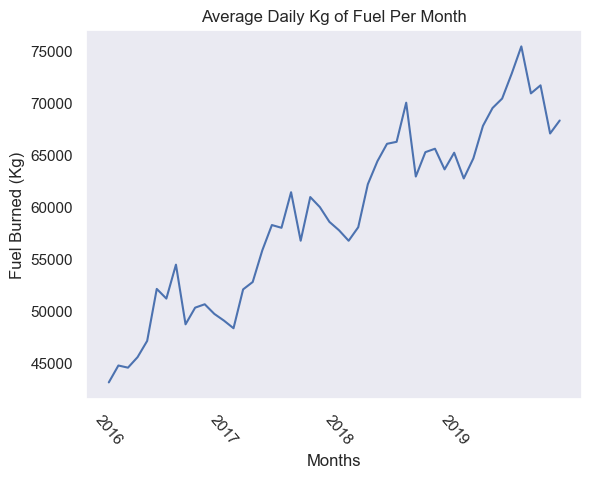

In [31]:
X2 = np.arange(0, len(monthly_final))
y2 = monthly_final['Fuel Per Day (kg/day)'].tolist()
plt.plot(X2, y2)
x_ticks = np.arange(0, len(X2), step=12)
x_labels = np.arange(2016, 2020)
plt.xticks(x_ticks, x_labels, rotation=310)
plt.title("Average Daily Kg of Fuel Per Month")
plt.xlabel("Months")
plt.ylabel("Fuel Burned (Kg)")
plt.show()

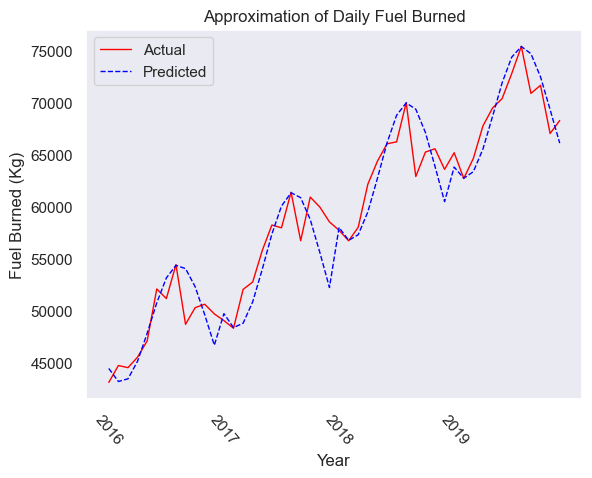

In [32]:
min_peaks2 = get_peaks(y2,min)
max_peaks2 = get_peaks(y2,max)
A2 = []
offset2 = []
for i in range(0, len(min_peaks2[1])):
    c_a = (max_peaks2[1][i] - min_peaks2[1][i])/2
    c_offset = min_peaks2[1][i] + c_a
    for j in range(0,T):
        A2.append(c_a)
        offset2.append(c_offset)
features2 = [X2, A2, offset2]

param, covariance = curve_fit(variable_sinusoid, features2, y2, p0=variable_get_p0(X2,y2))
plt.xticks(x_ticks, x_labels, rotation=310)
plt.title("Approximation of Daily Fuel Burned")
plt.ylabel("Fuel Burned (Kg)")
plt.xlabel("Year")
plt.plot(X2, y2, color="red", linewidth=1, label = 'Actual')
plt.plot(X2, variable_sinusoid(features2, *param), color="blue", linestyle="dashed", linewidth=1, label='Predicted')
plt.legend()
plt.show()

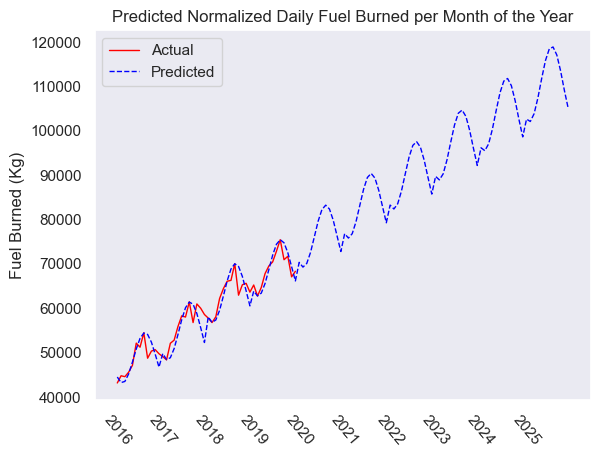

In [33]:
# reshape x_peaks
x_min_peaks2 = list(map(lambda l:[l], min_peaks2[0])) 
x_max_peaks2 = list(map(lambda l:[l], max_peaks2[0]))
# min model
model_min2 = linear_model.LinearRegression()
model_min2.fit(x_min_peaks2,min_peaks2[1])
# max model
model_max2 = linear_model.LinearRegression()
model_max2.fit(x_max_peaks2,max_peaks2[1])


yr_to_predict_to = 2025


yrs_into_future = yr_to_predict_to - 2019
for i in range(1, yrs_into_future + 1):
    x_min_peaks2.append([x_min_peaks2[len(x_min_peaks2) -1][0] + T])
    x_max_peaks2.append([x_max_peaks2[len(x_max_peaks2) -1][0] + T])
y_pred_min2 = model_min2.predict(x_min_peaks2)
y_pred_max2 = model_max2.predict(x_max_peaks2)

x_ticks_future = np.arange(0, len(X2)+yrs_into_future*12, step=12)
x_labels_future = np.arange(2016, yr_to_predict_to + 1)

X_pred2 = np.arange(0, len(X2) + T * yrs_into_future)
A_pred2 = A2.copy()
offset_pred2 = offset2.copy()
for i in range(yrs_into_future):
    index = len(max_peaks2[1]) + i
    c_a = (y_pred_max2[index] - y_pred_min2[index])/2
    c_offset = y_pred_min2[index] + c_a
    for j in range(0,T):
        A_pred2.append(c_a)
        offset_pred2.append(c_offset)
    features_pred2 = [X_pred2,A_pred2,offset_pred2]

plt.xticks(x_ticks_future, x_labels_future, rotation=310)
plt.plot(X2, y2, color="red", linewidth=1, label = 'Actual')
plt.plot(X_pred2, variable_sinusoid(features_pred2, *param), color="blue", linewidth=1, linestyle='dashed', label="Predicted")
plt.ylabel("Fuel Burned (Kg)")
plt.title("Predicted Normalized Daily Fuel Burned per Month of the Year")
plt.legend()
plt.show()

### Smoothing transitions

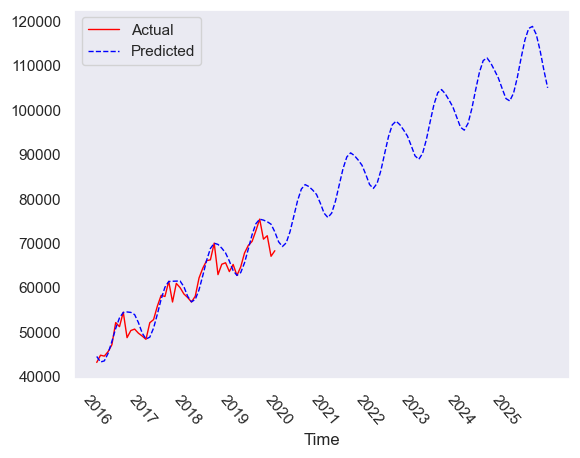

In [34]:
# smooth the features at transitions
A_smoothed = features_pred2[1]+np.diff(features_pred2[1],append=features_pred2[1][-1])/2
A_smoothed = A_smoothed+np.diff(A_smoothed,append=A_smoothed[-1])/2
A_smoothed = A_smoothed+np.diff(A_smoothed,append=A_smoothed[-1])/2
A_smoothed = A_smoothed+np.diff(A_smoothed,append=A_smoothed[-1])/2

offset_smoothed = features_pred2[2]+np.diff(features_pred2[2],append=features_pred2[2][-1])/2
offset_smoothed = offset_smoothed+np.diff(offset_smoothed,append=offset_smoothed[-1])/2
offset_smoothed = offset_smoothed+np.diff(offset_smoothed,append=offset_smoothed[-1])/2
offset_smoothed = offset_smoothed+np.diff(offset_smoothed,append=offset_smoothed[-1])/2

features_smoothed2 = [X_pred2, A_smoothed, offset_smoothed]


plt.xticks(x_ticks_future, x_labels_future, rotation=310)
plt.plot(X2, y2, color="red", linewidth=1, label = 'Actual')
plt.plot(X_pred2, variable_sinusoid(features_smoothed2, *param), color="blue", linewidth=1, linestyle='dashed', label="Predicted")
# plt.ylabel("Fuel Burned (Kg)")
plt.xlabel('Time')
# plt.title("Predicted Normalized Daily Fuel Burned per Month of the Year")
plt.legend()
plt.show()


### And the final $CO_2$ function!

In [35]:
def expected_CO2_emissions(month, year):
    assert year <= yr_to_predict_to, "Year " + year + " out of range."
    conversion = (year - 2016) * 12 + month
    const = 3.16
    kg_of_co2 = (int) (np.round(3.16 * (variable_sinusoid(features_smoothed2, *param)[conversion])))
    tonnes_of_co2 = (int) (np.round(kg_of_co2 / 1000))
    return "In " + str(month) + "/" + str(year) + ", there will be " + str(kg_of_co2) + " kg, or " + str(tonnes_of_co2) + " tonnes of CO2 released per day from SJC."

In [36]:
expected_CO2_emissions(3, 2023)

'In 3/2023, there will be 294983 kg, or 295 tonnes of CO2 released per day from SJC.'

## Wrap Up
Using similar methods to the previous two airports, I built a sinusoidal regression model for both the number of landings per day and the CO2 emitted on a day given a month and a year. Using historic data from 2016-2019, I was able to merged together several datasets in order to calculate the total CO2 emissions from SJC.